In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
import skimage.io
from skimage import transform 
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import transform
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.linear_model import LogisticRegression
from skimage.feature import hog

In [4]:
mat = scipy.io.loadmat('imagelabels.mat')
lb = mat['labels']

FileNotFoundError: [Errno 2] No such file or directory: 'imagelabels.mat'

In [3]:
def load_data(data_directory, num_images=None):
    labels = lb[0]
    images = []

    file_names = [f for f in os.listdir(data_directory) if f.endswith(".jpg")]

    if num_images:
        file_names = file_names[:num_images]

    for file_name in file_names:
        file_path = os.path.join(data_directory, file_name)
        img = skimage.io.imread(file_path)
        images.append(img)

    return images, labels

In [44]:
dataset , label = load_data('test')

In [45]:
label = label[:len(dataset)]

In [46]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.3, random_state= 41)

In [3]:
print (y_train)

NameError: name 'y_train' is not defined

In [48]:
print(y_test)

[88 77 77 77 88 77 88 73 88 73 73 88 77 73 77 73 73 73 77 73 88 73 73 73
 77 88 88 88 73 73 77 73 77 73 77 77 88 88 73 77 88 88 88 77 77 73 77 77
 73 73 73 88 73 73 88 77 88 77 88 73 77 88 73 88 73 77 73 77 88 88 88 73
 77 88 77 77 77 88 88 88 77 77 77 73 77 88 73 77 77 73 77 77 88 73 73 73
 88 73 77 88 88 77 77 77 77 77 77 77 73 73 73 88 88 77 77 77 73 77 77 73
 73 77 77 73 73 77 77 77 77 73 88 73 88 77 73 77 77 88 77 73 88 77 88 73
 73 73 77 77 88 77 77 77 73 77 73 77 77 77 88 73 88 77 73 88 73 77 77 73
 77 88 88 88 73 77 73 73 73 77 73 88]


In [49]:
# Function to Preprocess Images for HOG
def preprocess_images_for_hog(images, size=(32, 32)):
    processed_images = []
    for img in images:
        # Resize image
        resized_img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        
        # Convert to grayscale if it has three channels
        if resized_img.shape[-1] == 3:
            grayscale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        else:
            grayscale_img = resized_img
        
        processed_images.append(grayscale_img)
    return np.array(processed_images)

In [50]:
train_images_processed = preprocess_images_for_hog(x_train)
test_images_processed = preprocess_images_for_hog(x_test)

In [51]:
from sklearn.linear_model import LogisticRegression
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Compute HOG features for Training images
train_hog_features = []
for img in train_images_processed:
    hog_img = hog(img, visualize=False)
    train_hog_features.append(hog_img)

In [52]:
model = LogisticRegression(max_iter=1000)
model.fit(train_hog_features, y_train)

LogisticRegression(max_iter=1000)

In [53]:
from sklearn.linear_model import LogisticRegression
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Compute HOG features for test images
test_hog_features = []
for img in test_images_processed:
    hog_img = hog(img, visualize=False)
    test_hog_features.append(hog_img)

In [1]:
import matplotlib.pyplot as plt
from skimage import exposure

# Assuming test_images_processed is a list of processed test images
num_images_to_display = 2  # Set the number of images to display

for i in range(min(num_images_to_display, len(test_images_processed))):
    # Get the current color image
    img = test_images_processed[i]

    # Compute HOG features for the current image
    hog_img, hog_img_visual = hog(img, visualize=True)

    # Display the original color image and its HOG features
    plt.figure(figsize=(12, 6))

    # Display the original color image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    # Display the HOG features of the image
    plt.subplot(1, 3, 2)
    hog_img_visual_rescaled = exposure.rescale_intensity(hog_img_visual, in_range=(0, 10))
    plt.imshow(hog_img_visual_rescaled, cmap='gray')
    plt.title('HOG Features')

    plt.show()

    # Break the loop after displaying the specified number of images
    if i == num_images_to_display - 1:
        break


E:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


NameError: name 'test_images_processed' is not defined

In [54]:
# Predict on test set
predictions = model.predict(test_hog_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of logistic regression with HOG features: {accuracy}")

Accuracy of logistic regression with HOG features: 0.6611111111111111


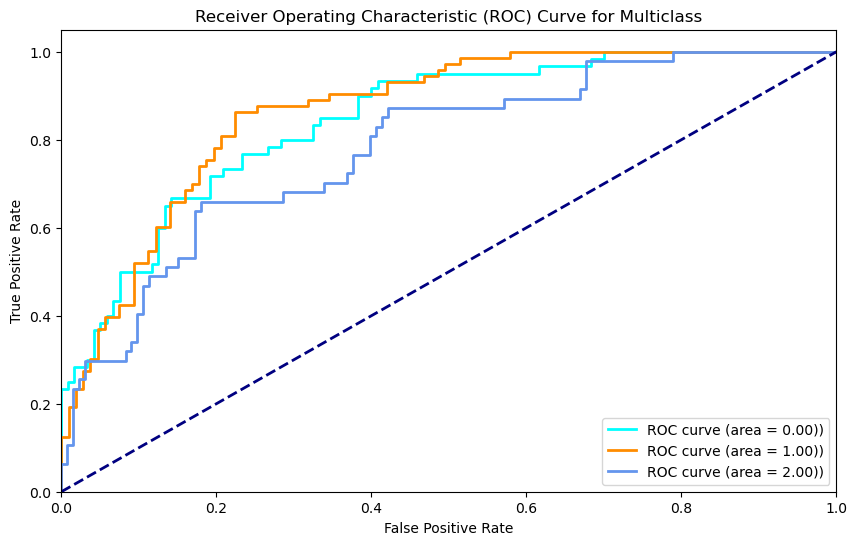

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get the decision function scores for each class
y_scores = model.decision_function(test_hog_features)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
colors = (['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}))'.format(i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()


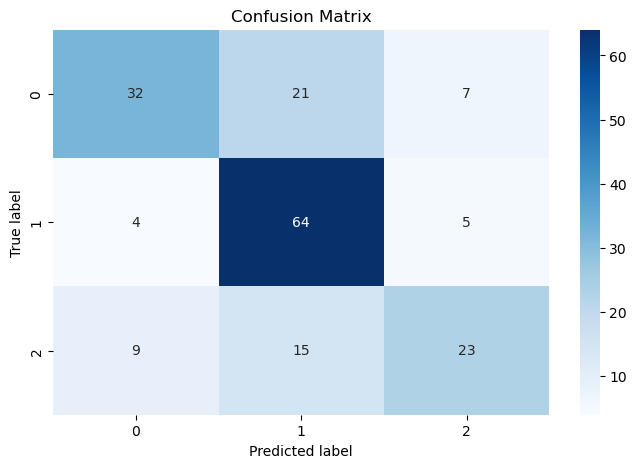

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()